In [5]:
import numpy as np, scipy, matplotlib
import matplotlib.pyplot as pl
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
from scipy.signal import detrend
%matplotlib notebook


In [21]:
g031_freq, g031_temp = np.loadtxt("G031.727.dat", unpack = 1)

#Get the stupid frequencies in ascending order
g031_freq = g031_freq[:: -1]
g031_temp = g031_temp[:: -1]

#Trim off the first 500 samples corresponding to bad baseline
g031_freq = g031_freq[300:]
g031_temp = g031_temp[300:]

<IPython.core.display.Javascript object>


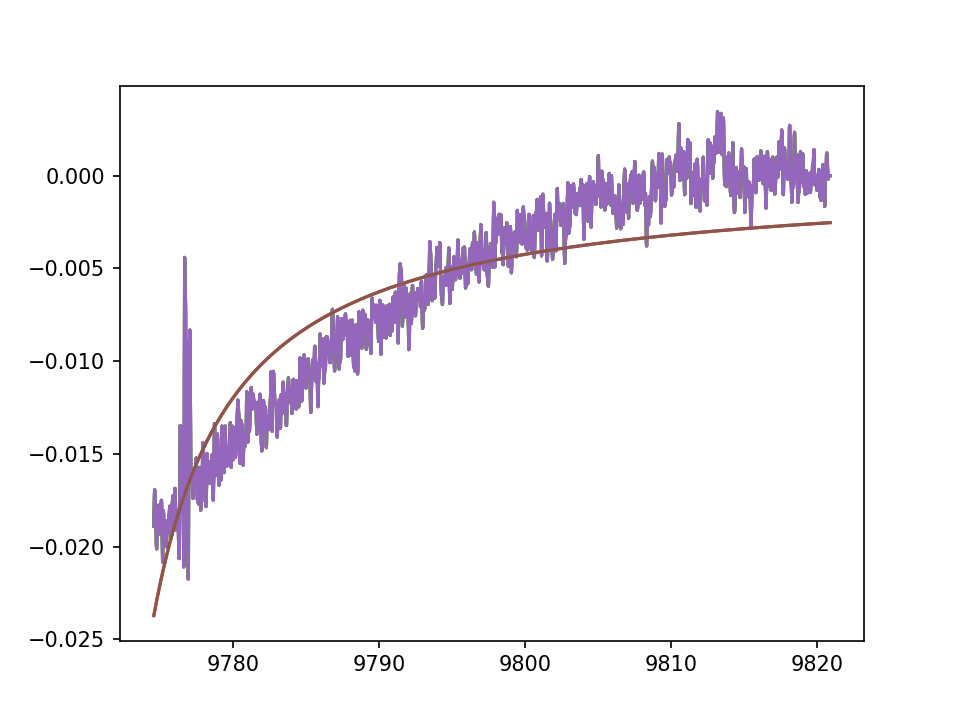

In [22]:
pl.plot(g031_freq, g031_temp)

<IPython.core.display.Javascript object>


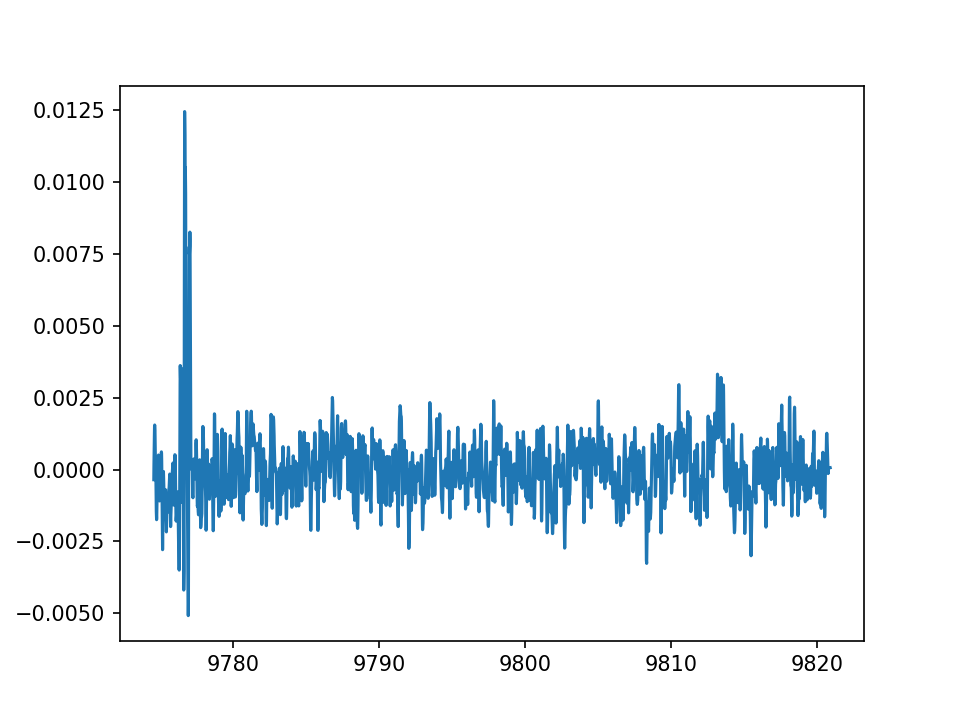

In [39]:
#Script to remove baseline
#Use polyfit instead of curve_fit as don't know the function

coeff = np.polyfit(g031_freq, g031_temp, 3)
baseline = np.poly1d(coeff)

g031_temp_corr = g031_temp - baseline(g031_freq)

pl.plot(g031_freq, g031_temp_corr)

<IPython.core.display.Javascript object>


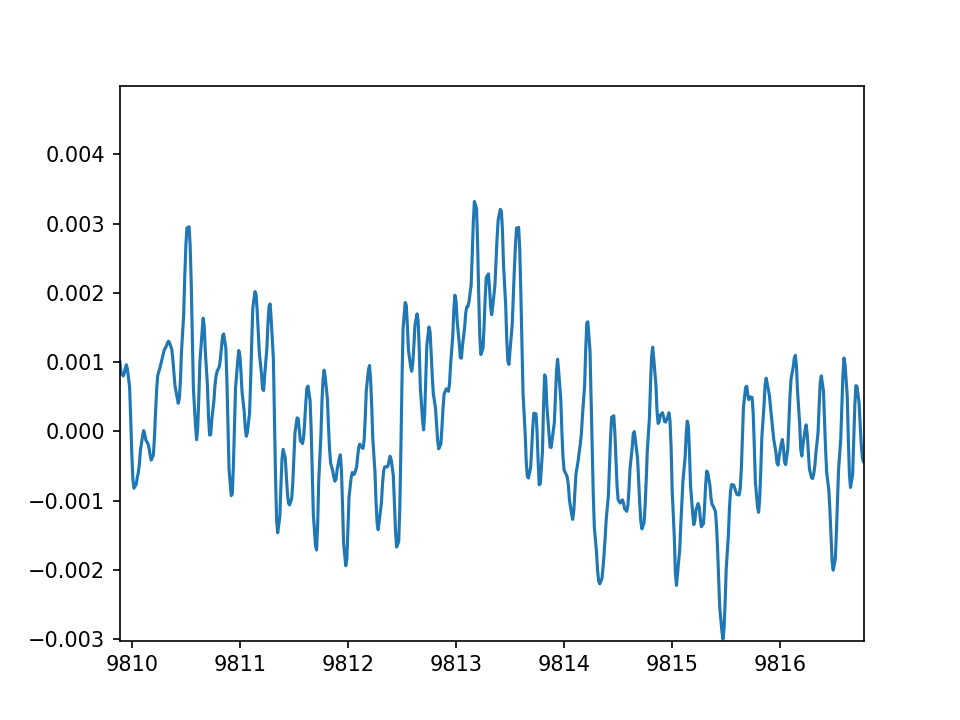

In [48]:
#Smooth the data, cause I can't see the line in this:

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

pl.plot(g031_freq, g031_temp_corr)